<h1 style="text-align: center; font-family: Verdana; font-size: 32px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; font-variant: small-caps; letter-spacing: 3px; color: #74d5dd; background-color: #ffffff;">Tissue Micro-Array (TMA) Labelling</h1>
<h2 style="text-align: center; font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: underline; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;">Algorithmic Approaches to Row-Wise Labelling</h2>
<h5 style="text-align: center; font-family: Verdana; font-size: 12px; font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color: black; background-color: #ffffff;">CREATED BY: DARIEN SCHETTLER</h5>


<h1 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; color: navy; background-color: #ffffff;">TABLE OF CONTENTS</h1>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#imports">0&nbsp;&nbsp;&nbsp;&nbsp;IMPORTS</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#background_information">1&nbsp;&nbsp;&nbsp;&nbsp;BACKGROUND INFORMATION</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#setup">2&nbsp;&nbsp;&nbsp;&nbsp;SETUP</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#helper_functions">3&nbsp;&nbsp;&nbsp;&nbsp;HELPER FUNCTIONS</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#cv2_approach">4&nbsp;&nbsp;&nbsp;&nbsp;CV2 BOUNDING BOX APPROACH</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#algo_approach_1">5&nbsp;&nbsp;&nbsp;&nbsp;ALGORITHMIC APPROACH #1</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#algo_approach_2">6&nbsp;&nbsp;&nbsp;&nbsp;ALGORITHMIC APPROACH #2</a></h3>

<br><br>

<a style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; color: navy; background-color: #ffffff;" id="imports">0&nbsp;&nbsp;IMPORTS</a>

<br>

In [1]:
# Run these commands first for installs
#    >>> !pip install openslide-python
#    >>> !pip install opencv-python
#    >>> !sudo apt-get install -y openslide-tools
#    >>> !sudo apt-get update
#    >>> !sudo apt-get install ffmpeg libsm6 libxext6  -y

# Run these commands next to get the data
#    >>> !mkdir -p ./data/svs_files
#    >>> !gsutil -m cp -r gs://ihc_dataset/quantiphi_testing/* ./data/svs_files

# Data Science Imports
import pandas as pd
import numpy as np
import random

# Microscopy Related Imports
import openslide
import tifffile

# Cloud Related Imports
from google.protobuf.struct_pb2 import Value
from google.protobuf import json_format
from google.cloud import aiplatform
from google.cloud import storage

# Visualization Imports
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from PIL import Image
import cv2

# Built In Imports
import base64
import glob
import os
import gc

<br><br>

<a style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; color: navy; background-color: #ffffff;" id="background_information">1&nbsp;&nbsp;BACKGROUND INFORMATION</a>

<br>

<br><br>

<a style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; color: navy; background-color: #ffffff;" id="setup">2&nbsp;&nbsp;SETUP</a>

<br>

In [4]:
# Set Paths
ROOT_DIR = "/home/jupyter/seattle-quantiphi/"
DATA_DIR = os.path.join(ROOT_DIR, "data")
SVS_DIR = os.path.join(DATA_DIR, "svs_files")
CORE_DIR = os.path.join(DATA_DIR, "core_images")

TMA_DIRS = [os.path.join(SVS_DIR, d_name) for d_name in os.listdir(SVS_DIR) if d_name.endswith("TMAs")]
CHALLENGE_DIR = os.path.join(SVS_DIR, "ChampionsTMA_21-24")

# Get all svs paths
SVS_PATHS = glob.glob(f'{SVS_DIR}/**/*.svs', recursive=True)
QPTIFF_PATHS = glob.glob(f'{SVS_DIR}/**/*.qptiff', recursive=True)

CHALLENGE_SVS_PATHS = [x for x in SVS_PATHS if "ChampionsTMA_21-24" in x]
SVS_PATHS = [x for x in SVS_PATHS if "ChampionsTMA_21-24" not in x]

CHALLENGE_QPTIFF_PATHS = [x for x in QPTIFF_PATHS if "ChampionsTMA_21-24" in x]
QPTIFF_PATHS = [x for x in QPTIFF_PATHS if "ChampionsTMA_21-24" not in x]

# Initialize Cloud Bucket
BUCKET = "ihc_dataset"

# Preparing out Storage Client for downloading the file
storage_client = storage.Client()
bucket = storage_client.get_bucket(BUCKET)

# Set threshold
C_THRESH=0.025

# Set plotting detail format
COLORS = [(int(x[0]*255), int(x[1]*255), int(x[2]*255)) for x in sns.color_palette("Spectral", 150)]
FONT = cv2.FONT_HERSHEY_SIMPLEX; FONT_SCALE = 0.7; FONT_THICKNESS = 2; FONT_LINE_TYPE = cv2.LINE_AA;

print(f"\n... Number of NON-CHALLENGE .SVS images ... \n\t--> {len(SVS_PATHS)}")
print(f"... Number of CHALLENGE .SVS images ... \n\t--> {len(CHALLENGE_SVS_PATHS)}")
print(f"\n... Number of NON-CHALLENGE .QPTIFF images ... \n\t--> {len(QPTIFF_PATHS)}")
print(f"... Number of CHALLENGE .QPTIFF images ... \n\t--> {len(CHALLENGE_QPTIFF_PATHS)}")


... Number of NON-CHALLENGE .SVS images ... 
	--> 23
... Number of CHALLENGE .SVS images ... 
	--> 15

... Number of NON-CHALLENGE .QPTIFF images ... 
	--> 10
... Number of CHALLENGE .QPTIFF images ... 
	--> 0


<br><br>

<a style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: navy;" id="helper_functions">3&nbsp;&nbsp;HELPER FUNCTIONS</a>

<br>

In [7]:
# dir_blob_tmp = [(tma_dir, bucket.get_blob(os.path.join(tma_dir.rsplit("/", 1)[1], filename))) for tma_dir in TMA_DIRS]
# cloud_dir, blob = [dir_blob for dir_blob in dir_blob_tmp if dir_blob[1] is not None][0]

In [8]:
# cloud_dir

In [30]:
def open_svs(path, extra_dwn=3):
    """ Simple function to open an SVS image and downscale
    
    Args:
        path (str): Path to the svs file to be returned
        extra_dwn (int, optional): The additional factor to downscale by
    
    Return:
        PIL Image of the downsampled image, downsample factor, downsampled dimensions
    """
    
    # Open the image and get the lowest tier dimensions and respective
    # downsampling factor
    slide = openslide.OpenSlide(path)
    new_dims = slide.level_dimensions[-1]
    dwn_sample = slide.level_downsamples[-1]
    
    # Perform extra-downsampling (or not) and return the 
    if not extra_dwn:
        return slide.read_region((0,0), slide.level_count-1, new_dims), slide.level_downsamples[-1], slide.level_dimensions[-1]
    else:
        new_dims = tuple([int(round(dim/3)) for dim in new_dims])
        dwn_sample = slide.dimensions[0]/new_dims[0]
        return Image.fromarray(cv2.resize(np.asarray(slide.read_region((0,0), slide.level_count-1, slide.level_dimensions[-1])), new_dims, cv2.INTER_AREA)), dwn_sample, new_dims
    
    
def get_bbox_from_svs(path, bbox_frac, resize_to=2048):
    """ Simple function to open an SVS image and downscale
    
    Args:
        path (str): Path to the svs file to be returned
        bbox_frac (list of floats): The bounding box coordinates
            as fractional values (xmin, ymin, xmax, ymax)
        resize_to (int, optional): The value to resize the image to (for model inference)
    
    Return:
        PIL Image of the desired core/bbox
    """
    
    # Open the image
    slide = openslide.OpenSlide(path)
    
    # Get dimensions
    slide_w, slide_h = slide.dimensions
    
    # Get bbox coordinates in native scale
    xmin,  ymin  = int(bbox_frac[0]*slide_w), int(bbox_frac[1]*slide_h)
    box_w, box_h = int((bbox_frac[2]-bbox_frac[0])*slide_w), int((bbox_frac[3]-bbox_frac[1])*slide_h)

    # Cut out the bbox
    bbox_cut_raw = slide.read_region(location=(xmin,ymin), level=0, size=(box_w, box_h))
    return Image.fromarray(cv2.resize(np.asarray(bbox_cut_raw), (resize_to,resize_to), cv2.INTER_AREA))


def save_cores_to_disk(bb_lbl_map, path_to_svs, output_dir=CORE_DIR, save_as_rgb=True):
    # Add required folder(s) and define paths
    tma_subdir, file_name = path_to_svs.rsplit(".", 1)[0].rsplit("/", 2)[1:]
    output_dir = os.path.join(output_dir, tma_subdir, file_name)
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    for row_ltr, bbox_list in tqdm(bb_lbl_map.items(), total=len(bb_lbl_map)):
        for row_idx, bbox in tqdm(enumerate(bbox_list), total=len(bbox_list)):
            
            individual_core_fname = os.path.join(output_dir, f"{file_name}__{row_ltr}{row_idx:02}.jpg")
            core_img = get_bbox_from_svs(path_to_svs, bbox)
            if save_as_rgb:
                core_img.convert("RGB").save(individual_core_fname.replace(".jpg", "_rgb.jpg"), quality=100)
            else:
                core_img.convert("L").save(individual_core_fname.replace(".jpg", "_gray.jpg"), quality=100)
    
    
def grab_contours(cnts):
    """ Return filtered contours -- from imutils library """
    # if the length the contours tuple returned by cv2.findContours
    # is '2' then we are using either OpenCV v2.4, v4-beta, or
    # v4-official
    if len(cnts) == 2:
        cnts = cnts[0]

    # if the length of the contours tuple is '3' then we are using
    # either OpenCV v3, v4-pre, or v4-alpha
    elif len(cnts) == 3:
        cnts = cnts[1]

    # otherwise OpenCV has changed their cv2.findContours return
    # signature yet again and I have no idea WTH is going on
    else:
        raise Exception(("Contours tuple must have length 2 or 3, "
            "otherwise OpenCV changed their cv2.findContours return "
            "signature yet again. Refer to OpenCV's documentation "
            "in that case"))

    # return the actual contours array
    return cnts


def get_wsi(file_path, cloud_dir="", save_to_disk=True, save_rgb_to_disk=False):
    """ Get WSI from cloud storage or local and save original/downsampled/rgb to disk 
    
    Args:
        file_path (str): Path to the slide on the local
        cloud_dir (str): Subfolder containing the image on the cloud to download
        save_to_disk (bool, optional): Whether to save the grayscale image
            to the local harddrive
        save_rgb_to_disk (bool, optional): Whether to save the RGB image
            to the local harddrive
    
    Returns: None; or, if `save_to_disk=False`, a numpy array containing the
        downscaled image.
    
    """
    
    # Get filename from filepath
    filename = file_path.rsplit("/", 1)[1]
    
    if not os.path.isfile(file_path):
        # Verbose What We're Doing
        print(f"\n ... Downloading {file_path} ...\n")
    
        # Figure out which of the 4 buckets the file is in and get the respective blob
        if not cloud_dir:
            dir_blob_tmp = [
                (tma_dir, bucket.get_blob(os.path.join(tma_dir.rsplit("/", 1)[1], filename))) \
                for tma_dir in TMA_DIRS
            ]
            cloud_dir, blob = [dir_blob for dir_blob in dir_blob_tmp if dir_blob[1] is not None][0]
    
        # Create the destination filepath
        dest_filepath = os.path.join(cloud_dir, filename)
    
        # Download the file from GCS
        blob.download_to_filename(dest_filepath)
    else:
        cloud_dir = file_path.rsplit("/", 2)[1] # subdirectory
        dest_filepath = file_path # where it's located on our local
        print("\t--> Already Downloaded")

    # Read the image dimensions
    print(f"\n\n ... Processing {filename} ...\n")
    wsi, dwn_sample, dwn_dimensions = open_svs(file_path)

    # Verbose Old Dimensions
    print("\t--> Original Slide Dimensions: " \
          f"{tuple([round(x*dwn_sample,0) for x in dwn_dimensions])}")
    
    # Verbose New Dimensions
    print("\t--> New Slide Dimensions: " \
          f"{dwn_dimensions}")

    # Save RGB to disk
    if save_rgb_to_disk:
        rgb_png_path = dest_filepath.replace(f".{filename.rsplit('.', 1)[1]}", 
                                             f"_{dwn_sample:.3f}_{dwn_dimensions[0]}_{dwn_dimensions[1]}.png")\
                                    .replace("svs_files", "rgb_downsampled")
        
        # Check if it exists and make if necessary
        if not os.path.isdir(rgb_png_path.rsplit("/", 1)[0]):
            os.makedirs(rgb_png_path.rsplit("/", 1)[0], exist_ok=True)
        
        wsi.convert("RGB").save(rgb_png_path, quality=100)

        print(f"\t--> Saved RGB Image as PNG To Disk: {rgb_png_path}")
    
    # Convert To Graysale
    wsi = wsi.convert("L")
    print(f"\t--> Resized Slide Dimensions: {dwn_dimensions}")

    # Save Grayscale to disk
    if save_to_disk:
        gray_png_path = dest_filepath.replace(f".{filename.rsplit('.', 1)[1]}", 
                                              f"_{dwn_sample:.3f}_{dwn_dimensions[0]}_{dwn_dimensions[1]}.png")\
                                     .replace("svs_files", "downsampled")

        # Check if it exists and make if necessary
        if not os.path.isdir(gray_png_path.rsplit("/", 1)[0]):
            os.makedirs(gray_png_path.rsplit("/", 1)[0], exist_ok=True)
        
        wsi.save(gray_png_path, quality=100)
        print(f"\t--> Saved as Grayscale PNG To Disk: {gray_png_path}")
        return gray_png_path
    else:
        print(f"\t--> Returning Image As Numpy Array")
        return np.asarray(wsi), dwn_sample, dwn_dimensions
    

def get_bb_iou(box_a, box_b):
    """ TBD """
    
    # determine the (x,y)-coordinates of the intersection rectangle
    x_a = max(box_a[0], box_b[0])
    y_a = max(box_a[1], box_b[1])
    x_b = min(box_a[2], box_b[2])
    y_b = min(box_a[3], box_b[3])

    # compute the area of intersection rectangle
    #     - do not include a +1 in these area calculations
    inter_area = max(0, x_b - x_a) * max(0, y_b - y_a)

    # compute the area of both the prediction and ground-truth rectangles
    #     - do not include a +1 in these area calculations
    box_a_area = (box_a[2] - box_a[0]) * (box_a[3] - box_a[1])
    box_b_area = (box_b[2] - box_b[0]) * (box_b[3] - box_b[1])
    
    if box_a_area > box_b_area:
        max_box_area = 'box_a'
    else:
        max_box_area = 'box_b'
        

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = inter_area / float(box_a_area + box_b_area - inter_area)

    # return the intersection over union value and box with max area
    return iou, max_box_area


def bbox_suppression(bboxes, centre_points, overlap_thresh=0.2):
    """ TBD """
    
    # if there are no boxes, return an empty list
    if len(bboxes) == 0:
        return []
    
    # initialize the list of picked indexes	
    indices_to_remove = []
    for i in range(len(bboxes)):
        for j in range(i+1, len(bboxes)):
            ith_bbox = bboxes[i]
            jth_bbox = bboxes[j]
            
            iou, max_box_area_str = get_bb_iou(ith_bbox, jth_bbox)
            if iou > overlap_thresh:
                
                # ith and jth box area - compare and return the winner
                if max_box_area_str == 'box_a':
                    indices_to_remove.append(i)
                else:
                    indices_to_remove.append(j)
                    
    bboxes = np.delete(bboxes, indices_to_remove, axis=0)
    centre_points = np.delete(centre_points, indices_to_remove, axis=0)
    
    return bboxes, centre_points

    
def predict_image_object_detection_sample(
    project: str,
    endpoint_id: str,
    filename: str,
    location: str = "us-central1",
    api_endpoint: str = "us-central1-prediction-aiplatform.googleapis.com",
):
    """ Get predictions from Google AIPlatform Endpoint """
    client_options = {"api_endpoint": api_endpoint}
    
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
    
    with open(filename, "rb") as f:
        file_content = f.read()

    # The format of each instance should conform to the deployed model's prediction input schema.
    encoded_content = base64.b64encode(file_content).decode("utf-8")
    instance_dict = {"content": encoded_content}

    instance = json_format.ParseDict(instance_dict, Value())
    instances = [instance]
    
    # See gs://google-cloud-aiplatform/schema/predict/params/image_object_detection_1.0.0.yaml for the format of the parameters.
    parameters_dict = {"confidenceThreshold": C_THRESH, "maxPredictions": 200}
    parameters = json_format.ParseDict(parameters_dict, Value())
    endpoint = client.endpoint_path(
        project=project, location=location, endpoint=endpoint_id
    )
    response = client.predict(
        endpoint=endpoint, instances=instances, parameters=parameters
    )
    print("response")
    print(" deployed_model_id:", response.deployed_model_id)
    # See gs://google-cloud-aiplatform/schema/predict/prediction/image_object_detection.yaml for the format of the predictions.
    predictions = response.predictions
    return predictions

def compute_bb_rows_1(bbs, cps, make_flexible=True):
    """ Get the bounding boxes by row """
    def __get_top_band(boxes, expansion_factor=0.01):
        """ Find the top band of bounding boxes """
        top_row = boxes[np.argmin(boxes[:, 1])][[1,3]]
        if expansion_factor:
            return np.array((top_row[0]*(1-expansion_factor), top_row[1]*(1+expansion_factor)))
        
    bb_rows = []
    while len(bbs)!=0:
        top_row_band = __get_top_band(bbs)
        top_row_idxs = np.where(np.less(cps[:, 1], top_row_band[1]))[0]
        top_row_bbs = bbs[top_row_idxs, :]

        if make_flexible:
            ymax = top_row_bbs[np.argmax(top_row_bbs[:, 3])][3]
            o_ymax = top_row_bbs[np.argmin(top_row_bbs[:, 3])][3]
            ymax = (ymax+o_ymax)/2
            top_row_idxs = np.where(np.less(cps[:, 1], ymax))[0]
            top_row_bbs = bbs[top_row_idxs, :]

        # Sort left-to-right
        sorted_top_row_bbs = top_row_bbs[np.argsort(top_row_bbs[:, 0])]

        # Append sorted list to master list
        bb_rows.append(sorted_top_row_bbs)
        
        # Remove from original array
        bbs = np.delete(bbs, top_row_idxs, axis=0)
        cps = np.delete(cps, top_row_idxs, axis=0)
        
    return bb_rows


def closest_cp(cp, cps, max_dy, x_step=1, y_step=5):
    """ Algorithmic way to find the closest Centre Point 
    
    This uses a modified version of Euclidean Distance.
    In the new coordinate system x is non-continuous 
        - negative jumps to very large positive
    and steps in the y-direction are much more costly
    
    Args:
        cp (nd.Array): Numpy array containing the centre-point 
            we want to use to calculate distance based on
        cps (nd.Array): Other centre-points for which we will calculate
            the closest centre-point to the original `cp` centre point.
        max_dy (float): Maximum distance the next centre-point can exist
            in the y-direction
        x_step (int, optional): The respective distance of one horizontal step in
            our modified coordinate system
        y_step (int, optional): The respective distance of one vertical step in
            our modified coordinate system
        """
    # Find the x distances between cp and all cps
    delta_x = (cps[..., 0] - cp[0])
    
    # Cast negative distances as 10000 (non-continuity)
    #    - This forces us to only look to the right
    delta_x = np.where(delta_x<0, 10000, delta_x)
    
    # Find the y distances between cp and all cps
    delta_y = np.abs((cps[..., 1] - cp[1]))
    
    # Find the combined distance after multiplying by new
    # coordinate system distances in each respective direction
    delta = (delta_x*x_step)+(delta_y*y_step)
    
    # Find the cp in the list of cps that is closest to the original cp
    # using the deltas as calculated with the new coordinate system rules
    min_index = np.argmin(delta)
    
    # If the nearest cp is VERY FAR AWAY (>10000) or 
    # if the nearest cp is more than max_dy away in the vertical direction
    # than we return None... else we return the index of the closest cp
    # to the original cp from the list of cps.
    if np.abs(cps[min_index][1]-cp[1])>max_dy or delta[min_index]>10000:
        return None
    else:
        return min_index
    

def get_bb_lbl_map_1(path_to_resized, preds, c_thresh=0.75, make_flexible=True, upper_cp=False, max_skew_angle=5):
    """ Algorithmic Approach 1 For Retrieving the BBOX Label Map 
    
    Args:
        path_to_resized (str): Path to the resized slide image saved to disk
        preds (AI Platform Predictions): Raw predictions from AI Platform
        c_thresh (float, optional): Confidence threshold to filter predictions upon
        make_flexible (bool, optional): Whether to increase row height 
            allowing for more flexibility
        upper_cp (bool, optional): Whether to use upper quarter instead of midpoint as
            the 'centre-point'
        max_skew_angle (int, optional): Maximum value for slide to be considered skewed
    
    Returns:
        A dictionary mapping rows (labelled with capital letters starting at `A`) 
        to a numpy array where each row in the array is the bbox coordinates for
        a tissue sample (sorted from left to right)
    """
    
    # Get dimensions of resized image from filename
    dimensions = np.array(path_to_resized[:-4].rsplit("_", 2)[1:], np.int32)
    
    # Filter confidences
    confidences_raw = preds[0]["confidences"]
    confidences = np.array([x for x in confidences_raw if x>c_thresh])
    
    # Capture bboxes, confidences and centre points above the threshold
    bboxes = np.zeros((confidences.size, 4), dtype=np.float32)
    centre_points = np.zeros((confidences.size, 2), dtype=np.float32)
    for i, bbox in enumerate(preds[0]["bboxes"]):
        if confidences_raw[i]>=c_thresh:
            bboxes[i, :2] = np.array(bbox)[[0,2]]
            bboxes[i, 2:] = np.array(bbox)[[1,3]]
            if not upper_cp:
                centre_points[i, :] = np.array([bbox[1]-(bbox[1]-bbox[0])/2, bbox[3]-(bbox[3]-bbox[2])/2])
            else:
                centre_points[i, :] = np.array([bbox[0]+(bbox[1]-bbox[0])/3, bbox[2]+(bbox[3]-bbox[2])/3])
    
    # Calculate skew of slide
    (cx, cy), (w,h), theta = cv2.minAreaRect(np.array(centre_points))
    skew_angle = 90%abs(theta)
    if skew_angle > max_skew_angle:
        print("\n\n================================================================================================")
        print(f"... Slide Is Skewed By At Least {skew_angle} Degrees.  Algorithmic Approach May Fail! ...")
        print("================================================================================================\n\n")
    
    # Get bbox rows
    bb_rows = compute_bb_rows_1(bboxes, centre_points, make_flexible)
    
    # Map bboxes to letter of the row for appropriate naming
    bb_lbl_map = {chr(65+i):bb for i, bb in enumerate(bb_rows)}
    return bb_lbl_map


def get_bb_lbl_map_2(path_to_resized, preds, dy_frac=0.5, tl_find_mult=5, do_nms=True):
    """ Algorithmic Approach 2 For Retrieving the BBOX Label Map 
    
    Args:
        path_to_resized (str): Path to the resized slide image saved to disk
        preds (AI Platform Predictions): Raw predictions from AI Platform
        dy_frac (float, optional): Fraction of bbox height to allow in vertical direction
        tl_find_mult (int, optional): Percentage to weight y dim vs x dim in tl corner search
    
    Returns:
        A dictionary mapping rows (labelled with capital letters starting at `A`) 
        to a numpy array where each row in the array is the bbox coordinates for
        a tissue sample (sorted from left to right)
    """    
    
    # Setup
    dimensions = np.array(path_to_resized[:-4].rsplit("_", 2)[1:], np.int32)
    raw_confidences = preds[0]["confidences"]
    confidences = np.array([x for x in raw_confidences if x>C_THRESH])
    bboxes = np.zeros((confidences.size, 4), dtype=np.float32)
    centre_points = np.zeros((confidences.size, 2), dtype=np.float32)

    for i, bbox in enumerate(preds[0]["bboxes"]):
        if raw_confidences[i] > C_THRESH:
            bboxes[i, :2] = np.array(bbox)[[0,2]]
            bboxes[i, 2:] = np.array(bbox)[[1,3]]
            centre_points[i, :] = np.array([bbox[0]+(bbox[1]-bbox[0])/2, bbox[2]+(bbox[3]-bbox[2])/2])

    if do_nms:
        bboxes, centre_points = bbox_suppression(bboxes, centre_points)
    
    # Initialization
    bb_lbl_map = {}
    max_dy = np.mean(np.diff(bboxes[:, [1,3]]))*dy_frac
    chr_idx = 65

    # The magic
    while len(bboxes)>0:
        # Get the new top_left bbox and remove it from cps and bbs
        tl_point = centre_points[np.argmin(bboxes[:, 1]*tl_find_mult+bboxes[:, 0])][:2]-0.01

        # First pass on repetition
        closest_idx = closest_cp(tl_point, centre_points, max_dy*2)

        current_cp = centre_points[closest_idx]
        bb_lbl_map[chr(chr_idx)] = [bboxes[closest_idx],]
        
        bboxes=np.delete(bboxes, closest_idx, axis=0)
        centre_points=np.delete(centre_points, closest_idx, axis=0)

        while len(bboxes)>0:
            closest_idx = closest_cp(current_cp, centre_points, max_dy)
            if closest_idx is None:
                break
            current_cp = centre_points[closest_idx]
            bb_lbl_map[chr(chr_idx)].append(bboxes[closest_idx])
            bboxes=np.delete(bboxes, closest_idx, axis=0)
            centre_points=np.delete(centre_points, closest_idx, axis=0)

        # Next Row Character
        chr_idx+=1
        
    bb_lbl_map = {k:np.stack(v) for k,v in bb_lbl_map.items()}
    return bb_lbl_map


def plot_image(bb_lbl_map, path_to_resized, opacity=0.5, cmap="Spectral", plot_row_boundaries=True, plot_box_midline=True, upper_cp=False):
    """ Plot Bounding Boxes By Row 
    
    Args:
        bb_lbl_map (dictionary): Mapping from row to numpy array containing bboxes
        path_to_resized (str): Path to downscaled image on disk
        opacity (float, optional): Opacity of the overlayed square for display
        cmap (string, optional): SNS Colourmap to be used
        plot_row_boundaries (bool, optional): Whether to show the edges of the rows
        plot_box_midline (bool, optional): Whether to show the centre-line of each box
        upper_cp (bool, optional): Whether to see the cetnre-point as the top quartile.

    Returns:
        None; An image will be plotted
    """
    def __get_scaled_bbox(bbox, dims):
        """ Scale the bounding box from float to the approrpiate integer dimensions """
        return int(bbox[0]*dims[1]), int(bbox[1]*dims[0]), int(bbox[2]*dims[1]), int(bbox[3]*dims[0])
    
    # Initialize arrays and colours
    COLORS = [(int(x[0]*255), int(x[1]*255), int(x[2]*255)) for x in sns.color_palette(cmap, len(bb_lbl_map))]
    random.shuffle(COLORS)
    FONT = cv2.FONT_HERSHEY_SIMPLEX; FONT_SCALE = 0.7; FONT_THICKNESS = 2; FONT_LINE_TYPE = cv2.LINE_AA;
    
    # Open the image and grab the dimensions
    img = np.asarray(Image.open(path_to_resized)).copy()
    dims = img.shape
    
    # Go row by row and plot the required shapes/text/lines
    plt.figure(figsize=(18,18))
    for i, (row_ltr, bb_list) in enumerate(bb_lbl_map.items()):
        if plot_row_boundaries:
            ymin = bb_list[np.argmin(bb_list[:, 1])][1]*dims[0]
            ymax = ((bb_list[np.argmax(bb_list[:, 3])][3]+bb_list[np.argmin(bb_list[:, 3])][3])/2)*dims[0]
            plt.hlines(ymin, 0, dims[1], colors=tuple([max((c-40)/255, 0.0) for c in COLORS[i]]+[0.45,]), linestyles='solid', linewidth=5)
            plt.hlines(ymax, 0, dims[1], colors=tuple([max((c-40)/255, 0.0) for c in COLORS[i]]+[0.45,]), linestyles='solid', linewidth=5)
        for j, bbox in enumerate(bb_list):
            
            bbox = __get_scaled_bbox(bbox, dims)
            rect = np.uint8(np.ones((bbox[3]-bbox[1], bbox[2]-bbox[0], 3))*COLORS[i])
            cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), tuple([max((c-40), 0) for c in COLORS[i]]), FONT_THICKNESS)
            overlay = cv2.addWeighted(img[bbox[1]:bbox[3],bbox[0]:bbox[2],:], 1-opacity, rect, opacity, 1.0)    
            img[bbox[1]:bbox[3],bbox[0]:bbox[2],:] = overlay
            
            if plot_box_midline:
                if not upper_cp:                    
                    plt.hlines(bbox[1]+(bbox[3]-bbox[1])//2, bbox[0], bbox[2], colors=tuple([max((c-40)/255, 0) for c in COLORS[i]]+[0.75,]), linestyles='dashed', linewidth=2)
                else:
                    plt.hlines(bbox[1]+(bbox[3]-bbox[1])//3, bbox[0], bbox[2], colors=tuple([max((c-40)/255, 0) for c in COLORS[i]]+[0.75,]), linestyles='dashed', linewidth=2)
            
            txt_lbl = f"{row_ltr}{j}"
            text_width, text_height = cv2.getTextSize(txt_lbl, FONT, FONT_SCALE, FONT_THICKNESS)[0]
            cv2.putText(img, txt_lbl, (bbox[0]+((bbox[2]-bbox[0])//2)-(text_width//2), (bbox[1]+((bbox[3]-bbox[1])//2)+(text_height//2))),
                        FONT, FONT_SCALE, [max((c-70), 0) for c in COLORS[i]], FONT_THICKNESS, FONT_LINE_TYPE)

    plt.imshow(img)
    plt.title(path_to_resized.rsplit("/", 1)[1], fontweight="bold")
    plt.axis(False)
    plt.show()

<br><br>

<a style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: navy;" id="cv2_approach">4&nbsp;&nbsp;CV2 BOUNDING BOX APPROACH</a>

<br>

In [10]:
def __get_scaled_bbox(bbox, dims):
        """ Scale the bounding box from float to the approrpiate integer dimensions """
        return int(bbox[0]*dims[1]), int(bbox[1]*dims[0]), int(bbox[2]*dims[1]), int(bbox[3]*dims[0])

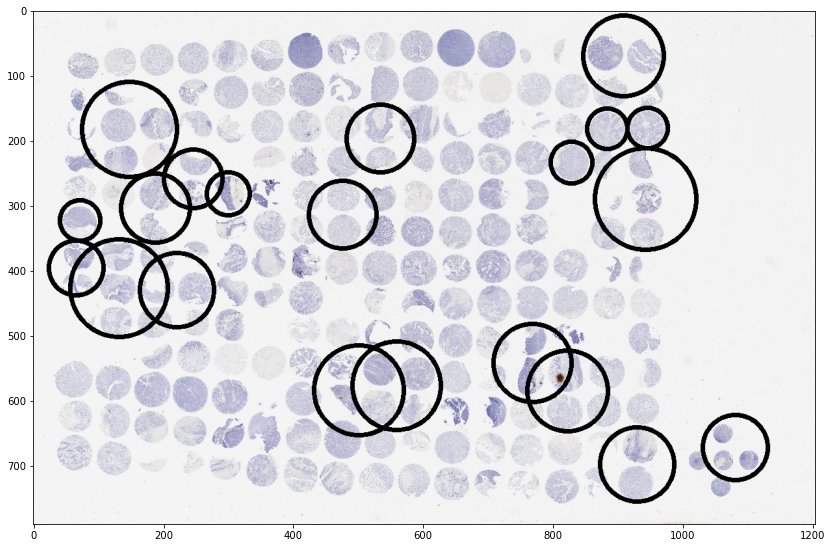

In [12]:
DEMO_PATH = CHALLENGE_SVS_PATHS[0]
slide, _, _ = open_svs(DEMO_PATH)

gray = np.asarray(slide.convert("L"))
slide = np.asarray(slide.convert("RGB"))

blurred = cv2.GaussianBlur(gray, (31,31), 0)
thresh = cv2.threshold(blurred, 222, 255, cv2.THRESH_BINARY_INV)[1]

for i in range(2):
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)

cnts = grab_contours(cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE))
min_enclosing_circles = [cv2.minEnclosingCircle(cv2.approxPolyDP(c, 3, True)) for c in cnts]  
average_circle_radius = np.average([x[1] for x in min_enclosing_circles])
min_enclosing_circles = [x for x in min_enclosing_circles if (x[1]>=(0.8*average_circle_radius) and (x[1]<2.5*average_circle_radius))]

copy = slide.copy()
for circ in min_enclosing_circles:
    cv2.circle(copy, tuple([int(round(x)) for x in circ[0]]), int(round(circ[1])), (0,0,0), 6)


plt.figure(figsize=(14,14))
plt.imshow(copy)
plt.show()

<br><br>

<a style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: navy;" id="algo_approach_1">5&nbsp;&nbsp;ALGORITHMIC APPROACH 1</a>

<br>

In [ ]:
# ########################################################## #
# ########################## DEMO ########################## #
# ########################################################## #
path = CHALLENGE_SVS_PATHS[2]
path_to_resized = get_wsi(path, save_rgb_to_disk=True)
preds = predict_image_object_detection_sample(
    "ihc-qc-sandbox",      # PROJECT ID
    "4721514035902676992", # MODEL ID     - AutoML Vision
    path_to_resized        # File (bytes) - To pass to AutoML Vision
    )

# Get the bounding boxes labelled
bb_lbl_map = get_bb_lbl_map_1(path_to_resized, preds)

# Plot the image and labels
plot_image(bb_lbl_map, path_to_resized.replace("downsampled", "rgb_downsampled")) 
# ########################################################## #
# ########################################################## #
# ########################################################## #

<br><br>

<a style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: navy;" id="algo_approach_2">5&nbsp;&nbsp;ALGORITHMIC APPROACH #2</a>

<br>

The current best approach

DEMO

	--> Already Downloaded


 ... Processing 26107_TMA23.svs ...

	--> Original Slide Dimensions: (55776.0, 42576.0)
	--> New Slide Dimensions: (1162, 887)
	--> Saved RGB Image as PNG To Disk: /home/jupyter/seattle-quantiphi/data/rgb_downsampled/ChampionsTMA_21-24/26107_TMA23_48.000_1162_887.png
	--> Resized Slide Dimensions: (1162, 887)
	--> Saved as Grayscale PNG To Disk: /home/jupyter/seattle-quantiphi/data/downsampled/ChampionsTMA_21-24/26107_TMA23_48.000_1162_887.png
response
 deployed_model_id: 6095182290994855936


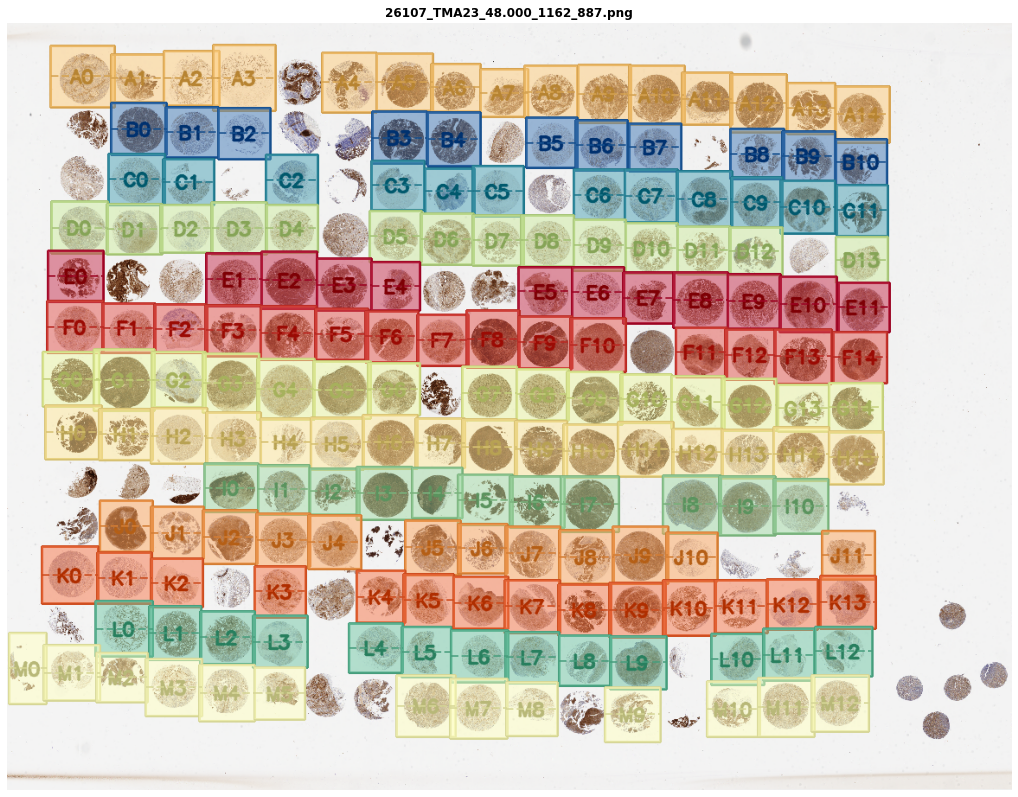

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [31]:
SAVE_CORES = True

# ########################################################## #
# ########################## DEMO ########################## #
# ########################################################## #
path = CHALLENGE_SVS_PATHS[-4]
path_to_resized = get_wsi(path, save_rgb_to_disk=True)
preds = predict_image_object_detection_sample(
    "ihc-qc-sandbox",        # PROJECT ID   - Not the same as the one with characters in it
    "4721514035902676992",   # MODEL ID     - AutoML Vision
    path_to_resized          # File (bytes) - To pass to AutoML Vision
    )

# Get the bounding boxes labelled
bb_lbl_map = get_bb_lbl_map_2(path_to_resized, preds, do_nms=True)

# Plot the image and labels
plot_image(bb_lbl_map, path_to_resized.replace("downsampled", "rgb_downsampled"), plot_row_boundaries=False)

if SAVE_CORES:
    # Cut out cores
    save_cores_to_disk(bb_lbl_map, path)

# ########################################################## #
# ########################################################## #
# ########################################################## #

RUN THROUGH ALL FILES

In [ ]:
PLOT_AS_WE_GO=True
SAVE_CORES = False

# ########################################################## #
# ############## DO ALL REGULAR SVS IMAGES ################# #
# ########################################################## #

for path in SVS_PATHS:
    path_to_resized = get_wsi(path, save_rgb_to_disk=True)
    preds = predict_image_object_detection_sample(
        "ihc-qc-sandbox",        # PROJECT ID   - Not the same as the one with characters in it
        "4721514035902676992",   # MODEL ID     - AutoML Vision
        path_to_resized        # File (bytes) - To pass to AutoML Vision
        )

    # Get the bounding boxes labelled
    bb_lbl_map = get_bb_lbl_map_2(path_to_resized, preds)

    if PLOT_AS_WE_GO:
        # Plot the image and labels
        plot_image(bb_lbl_map, path_to_resized.replace("downsampled", "rgb_downsampled"), plot_row_boundaries=False)    
        
    if SAVE_CORES:
        # Cut out cores
        save_cores_to_disk(bb_lbl_map, path)

    
# ########################################################## #
# ########################################################## #
# ########################################################## #


In [ ]:
PLOT_AS_WE_GO=True
SAVE_CORES = False

# ########################################################## #
# ############# DO ALL CHALLENGE SVS IMAGES ################ #
# ########################################################## #

for path in CHALLENGE_SVS_PATHS:
    path_to_resized = get_wsi(path, save_rgb_to_disk=True)
    preds = predict_image_object_detection_sample(
        "ihc-qc-sandbox",        # PROJECT ID   - Not the same as the one with characters in it
        "4721514035902676992",   # MODEL ID     - AutoML Vision
        path_to_resized        # File (bytes) - To pass to AutoML Vision
        )

    # Get the bounding boxes labelled
    bb_lbl_map = get_bb_lbl_map_2(path_to_resized, preds)

    if PLOT_AS_WE_GO:
        # Plot the image and labels
        plot_image(bb_lbl_map, path_to_resized.replace("downsampled", "rgb_downsampled"), plot_row_boundaries=False)    
        
    if SAVE_CORES:
        # Cut out cores
        save_cores_to_disk(bb_lbl_map, path)

        
    
# ########################################################## #
# ########################################################## #
# ########################################################## #


In [ ]:
PLOT_AS_WE_GO=True
SAVE_CORES = False

# ########################################################## #
# ################ DO ALL QPTIFF IMAGES #################### #
# ########################################################## #

# There are no QPTIFF_CHALLENGE_PATHS but I'm including it for completeness
for path in QPTIFF_PATHS+CHALLENGE_QPTIFF_PATHS:
    path_to_resized = get_wsi(path, save_rgb_to_disk=True)
    preds = predict_image_object_detection_sample(
        "ihc-qc-sandbox",        # PROJECT ID   - Not the same as the one with characters in it
        "4721514035902676992",   # MODEL ID     - AutoML Vision
        path_to_resized        # File (bytes) - To pass to AutoML Vision
        )

    # Get the bounding boxes labelled
    bb_lbl_map = get_bb_lbl_map_2(path_to_resized, preds)

    if PLOT_AS_WE_GO:
        # Plot the image and labels
        plot_image(bb_lbl_map, path_to_resized.replace("downsampled", "rgb_downsampled"), plot_row_boundaries=False)    
    
    if SAVE_CORES:
        # Cut out cores
        save_cores_to_disk(bb_lbl_map, path)

# ########################################################## #
# ########################################################## #
# ########################################################## #
